# Baldur's Gate 3 Steam Reviews EDA
Mahan Madani - Mohammad Mehdi Begmaz

## Load Dataset and import libraries

In [13]:
import os, zipfile
import re

import pandas as pd
import numpy as np
from profanity_check import predict

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# !pip install kaggle

# Upload your kaggle.json file and replace the path below
os.environ['KAGGLE_CONFIG_DIR'] = "./.kaggle"

!kaggle datasets download -p ./dataset harisyafie/baldurs-gate-3-steam-reviews

baldurs-gate-3-steam-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
with zipfile.ZipFile('./dataset/baldurs-gate-3-steam-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset')

In [2]:
df = pd.read_csv("dataset/BG3_reviews_updated.csv")
print(df.columns)
print(df.shape)

Index(['recommendationid', 'language', 'review', 'timestamp_created',
       'timestamp_updated', 'voted_up', 'votes_up', 'votes_funny',
       'weighted_vote_score', 'written_during_early_access', 'comment_count',
       'steam_purchase', 'received_for_free'],
      dtype='object')
(309103, 13)


## Basic Data Analysis

In [5]:
df.head(3)

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,written_during_early_access,comment_count,steam_purchase,received_for_free
0,153560814,english,This game hits all the right marks. 10/10,1702542971,1702542971,True,0,0,0.0,False,0,True,False
1,153560623,english,took me like 11 hours to understand the basics,1702542657,1702542657,True,0,0,0.0,False,0,True,False
2,153560414,english,10/10 game play and story! It's my first turn ...,1702542275,1702542275,True,0,0,0.0,False,0,True,False


In [6]:
df.describe(include=['object', 'bool'])

,language,review,voted_up,written_during_early_access,steam_purchase,received_for_free
count,309103,308086,309103,309103,309103,309103
unique,1,255104,2,2,2,2
top,english,good,True,False,True,False
freq,309103,1937,298932,261055,278256,306024


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309103 entries, 0 to 309102
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   recommendationid             309103 non-null  int64  
 1   language                     309103 non-null  object 
 2   review                       308086 non-null  object 
 3   timestamp_created            309103 non-null  int64  
 4   timestamp_updated            309103 non-null  int64  
 5   voted_up                     309103 non-null  bool   
 6   votes_up                     309103 non-null  int64  
 7   votes_funny                  309103 non-null  int64  
 8   weighted_vote_score          309103 non-null  float64
 9   written_during_early_access  309103 non-null  bool   
 10  comment_count                309103 non-null  int64  
 11  steam_purchase               309103 non-null  bool   
 12  received_for_free            309103 non-null  bool   
dtyp

Handle null values and duplicate values

In [3]:
null_counts = df.isnull().sum()
null_table = pd.DataFrame(null_counts, columns=["Null Count"])
null_table

,Null Count
recommendationid,0
language,0
review,1017
timestamp_created,0
timestamp_updated,0
voted_up,0
votes_up,0
votes_funny,0
weighted_vote_score,0
written_during_early_access,0


In [4]:
df.dropna()
df.shape

(309103, 13)

In [5]:
duplicated = df.duplicated(subset=['review'], keep=False)
duplicate_rows = df[duplicated]

if not duplicate_rows.empty:
    print("Duplicate records found:")
    print(duplicated.sum())
else:
    print("No duplicate records found.")

Duplicate records found:
60446


In [6]:
df = df.drop_duplicates(subset='review', keep='first').reset_index(drop=True)
print("Dataframe with no duplicate values:")
print(df.shape)

Dataframe with no duplicate values:
(255105, 13)


## Feature Transformation

In [7]:
def clean_text(text):

    # stop_words = set(stopwords.words('english'))
    # word_tokens = word_tokenize(text)
    # text = ' '.join([word for word in word_tokens if word not in stop_words])

    cleaned_text = text.lower().replace('\n', ' ')
    cleaned_text = re.sub('\[.*?\]', '', cleaned_text)
    cleaned_text = re.sub('[^a-zA-Z0-9()/!?&\'",. ]', '', cleaned_text)

    return cleaned_text

In [8]:
df['review'] = df['review'].astype(str)
df['review'] = df['review'].apply(clean_text)

In [9]:
df = df.drop(columns=['recommendationid', 'language','timestamp_created',
       'timestamp_updated', 'written_during_early_access', 'comment_count',
       'steam_purchase', 'received_for_free'])

## Feature Engineering

In [10]:
df['word_count'] = df['review'].apply(lambda text: len(text.split()))
df['word_count'].describe()

count    255105.000000
mean         44.504373
std          95.168806
min           0.000000
25%           7.000000
50%          16.000000
75%          42.000000
max        2286.000000
Name: word_count, dtype: float64

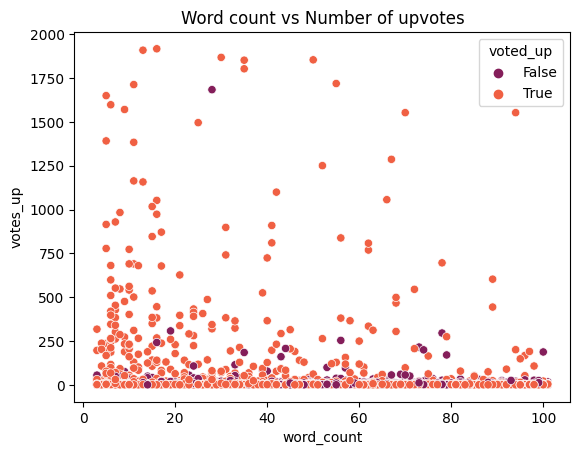

In [19]:
Q1 = df['word_count'].quantile(0.1)
Q3 = df['word_count'].quantile(0.9)

selected_records = df[(df['word_count'] >= Q1) &
                       (df['word_count'] <= Q3) &
                         (df['votes_up'] > 0) &
                           (df['votes_up'] < 2000)]

ax = sns.scatterplot(y='votes_up',
                x='word_count',
                hue='voted_up',
                palette='rocket',
                data=selected_records)
ax.set_title('Word count vs Number of upvotes')
plt.show()

In [21]:
filtered_df = df[df['votes_up'] > 0].reset_index(drop=True)

In [22]:
filtered_df = filtered_df[filtered_df['weighted_vote_score'] > 0.5].reset_index(drop=True)

In [23]:
filtered_df = filtered_df[filtered_df['word_count'] > 30].reset_index(drop=True)
filtered_df = filtered_df[filtered_df['word_count'] < 1000].reset_index(drop=True)

Delete reviews with profanity

In [24]:
filtered_df['profanity'] = pd.DataFrame(predict(filtered_df['review']))
filtered_df['profanity'].value_counts()

0    17371
1      377
Name: profanity, dtype: int64

In [25]:
filtered_df = filtered_df[filtered_df['profanity'] == False]

Save preprocessed dara

In [26]:
filtered_df = filtered_df.sort_values(by='weighted_vote_score', ascending=False).reset_index(drop=True)
filtered_df['voted_up'].head(10000).value_counts()

True     9609
False     391
Name: voted_up, dtype: int64

In [27]:
filtered_df.shape

(17371, 7)

In [28]:
filtered_df.head(10000).to_csv('./dataset/BG3_reviews_preprocessed.csv', index=False)